In [1]:
from bs4 import BeautifulSoup
import jieba
import jieba.analyse
import pymongo
import pandas as pd
import numpy as np
import requests
import re
import os
import json
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import warnings

warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = 'all'

sns.set(style="white", context="talk")
sns.set(font="simhei")

font1 = {'family' : 'Times New Roman',
        'weight' : 'normal',
        'size'   : 23,
}

#### load data

In [3]:
client = pymongo.MongoClient("mongodb://localhost:27017/")
weibo_db = client["weibo"]
user_table = weibo_db['user']
post_table = weibo_db['post']
comment_table = weibo_db['comment']

In [4]:
post_table.find_one({'_id':7044218812})

In [5]:
print('user size')
user_table.find().count()
print('post size')
post_table.find().count()
print('comment size')
comment_table.find().count()

user size


186

post size


15013

comment size


300345

In [6]:
user_list = [u for u in user_table.find()]
user_list = sorted(user_list, key=lambda x:x['_id'])
column_list = sorted(list(set(k for u in user_list for k in u.keys())))
user_df = pd.DataFrame(user_list,columns=column_list)
user_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186 entries, 0 to 185
Data columns (total 17 columns):
_id                186 non-null int64
birthday           89 non-null object
description        186 non-null object
emotion            7 non-null object
follow_count       186 non-null int64
follower           101 non-null object
followers_count    186 non-null int64
following          101 non-null object
gender             186 non-null object
location           185 non-null object
other              106 non-null object
screen_name        186 non-null object
statuses_count     186 non-null int64
validation         101 non-null object
verified           186 non-null bool
verified_reason    186 non-null object
verified_type      186 non-null object
dtypes: bool(1), int64(4), object(12)
memory usage: 23.5+ KB


In [7]:
# 平均粉丝数
user_df['followers_count'].mean()
# 平均关注数
user_df['follow_count'].mean()
# 平均微博数
user_df['statuses_count'].mean()

15790596.231182795

599.4301075268817

17859.983870967742

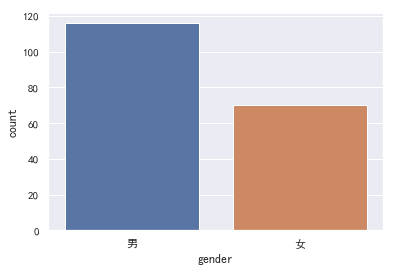

In [261]:
sns.countplot(x='gender',data=user_df)

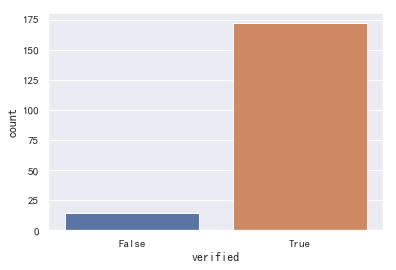

In [262]:
sns.countplot(x='verified',data=user_df)

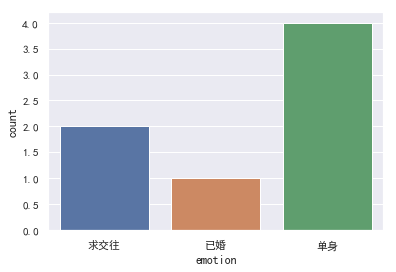

In [263]:
sns.countplot(x='emotion',data=user_df)

#### 年龄比例

In [17]:
user_df['birthday'].isna().value_counts()

True     97
False    89
Name: birthday, dtype: int64

In [83]:
def age_map_fn(x):
    x = str(x)
    if '-' in x:
        x = x.split('-')[0]
        if x < '1980':
            return '70'
        if x < '1990':
            return '80'
        if x < '2000':
            return '90'
        if x < '2010':
            return '00'
        if x < '2020':
            return '10'
        return np.random.choice(['90','00','10'])
    else:
        return np.random.choice(['90','00','10'])

In [85]:
user_df['age_state'] = user_df['birthday'].apply(age_map_fn)

In [86]:
user_df['age_state'].value_counts()

90    67
10    38
00    37
70    27
80    17
Name: age_state, dtype: int64

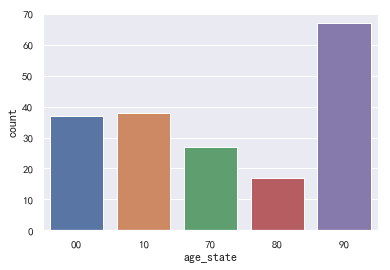

In [87]:
sns.countplot(x='age_state',data=user_df)

#### 职业比例

In [92]:
user_df['title'] = user_df['description']+user_df['other']+user_df['validation']

In [129]:
def position_map_fn(x):
    x = str(x)
    position = ['演员','歌手','娱乐','自媒体','主持人','博主']
    for p in position:
        if p in x:
            if p == '博主':
                return '知名博主'
            return p
    return np.random.choice(['演员','歌手','知名博主','其他'])

In [130]:
user_df['position'] = user_df['title'].apply(position_map_fn)

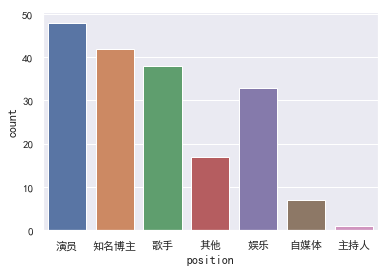

In [132]:
sns.countplot(x='position',data=user_df)

In [56]:
## 异常值处理
# str_columns = list(set(user_df.columns) - set(user_df.describe().columns))
# for col in str_columns:
#     if user_df[col].isna().any():
#         user_df[col].fillna(user_df[col].mode()[0], inplace=True)
# user_df

#### 情感+性别比例

In [264]:
# plt.figure(figsize=(9,15))
# plt.subplot(311)
# sns.countplot(data=user_df, x='emotion', hue = 'emotion')
# plt.subplot(312)
# sns.countplot(data=user_df, x='gender', hue = 'gender')
# plt.subplot(313)
# sns.countplot(data=user_df, x='gender',hue='emotion')

#### 用户地区分布

In [13]:
'''
pip install pyecharts 
pip install echarts-countries-pypkg
pip install echarts-china-provinces-pypkg
pip install echarts-china-cities-pypkg
'''
def sigmoid(x):
    return 1/(1+np.exp(-x))

user_df['location'] = user_df['location'].fillna('上海')
user_df['province'] = [x.split(' ')[0] for x in user_df['location'].values]
geo_coord_map = json.load(open('geo_coord_map.json','r'))
# json.dump(geo_coord_map,open('geo_coord_map.json','w'))

province_count = user_df['province'].value_counts()
_min = province_count[-1]
_max = province_count[0]

view_data=[]
for pro in set(user_df['province'].values):
    if len(pro) > 2:
        continue
    if pro in ['海外','其他','美国']:#只统计中国区域
        continue
    # html
#     view_data.append({'name': pro, 'value':sigmoid(province_count[pro])*100})#:province_count[pro]*10 + (_max-_min)/2
    # ptecahrts
    view_data.append((pro,sigmoid(province_count[pro])*100))

'\npip install pyecharts \npip install echarts-countries-pypkg\npip install echarts-china-provinces-pypkg\npip install echarts-china-cities-pypkg\n'

In [14]:
view_data

[('湖南', 95.25741268224334),
 ('新疆', 73.1058578630005),
 ('广东', 99.98766054240137),
 ('台湾', 99.75273768433654),
 ('河北', 73.1058578630005),
 ('江苏', 88.07970779778823),
 ('重庆', 99.33071490757153),
 ('北京', 100.0),
 ('香港', 98.20137900379085),
 ('上海', 99.99999979388463),
 ('贵州', 73.1058578630005),
 ('浙江', 88.07970779778823),
 ('天津', 73.1058578630005),
 ('四川', 88.07970779778823),
 ('湖北', 73.1058578630005),
 ('福建', 73.1058578630005)]

In [15]:
from pyecharts import Geo
 
data = view_data
geo = Geo('关注的微博用户注册地区的分布', '省份: {}个,用户: {}个'.format(len(view_data),len(user_df)), title_color="#fff",
          title_pos="center", width=1000,
          height=600, background_color='#404a59')
attr, value = geo.cast(data)
geo.add("", attr, value, visual_range=[0, 200], maptype='china',visual_text_color="#fff",
        symbol_size=20, is_visualmap=True)
#geo.render("关注的微博用户注册地区的分布.html")#生成html文件

#### 微博数目,转发数目,粉丝数目

<Figure size 1440x1944 with 0 Axes>

Text(0.5,1,'followers_count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5,1,'follow_count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

Text(0.5,1,'statuses_count')

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

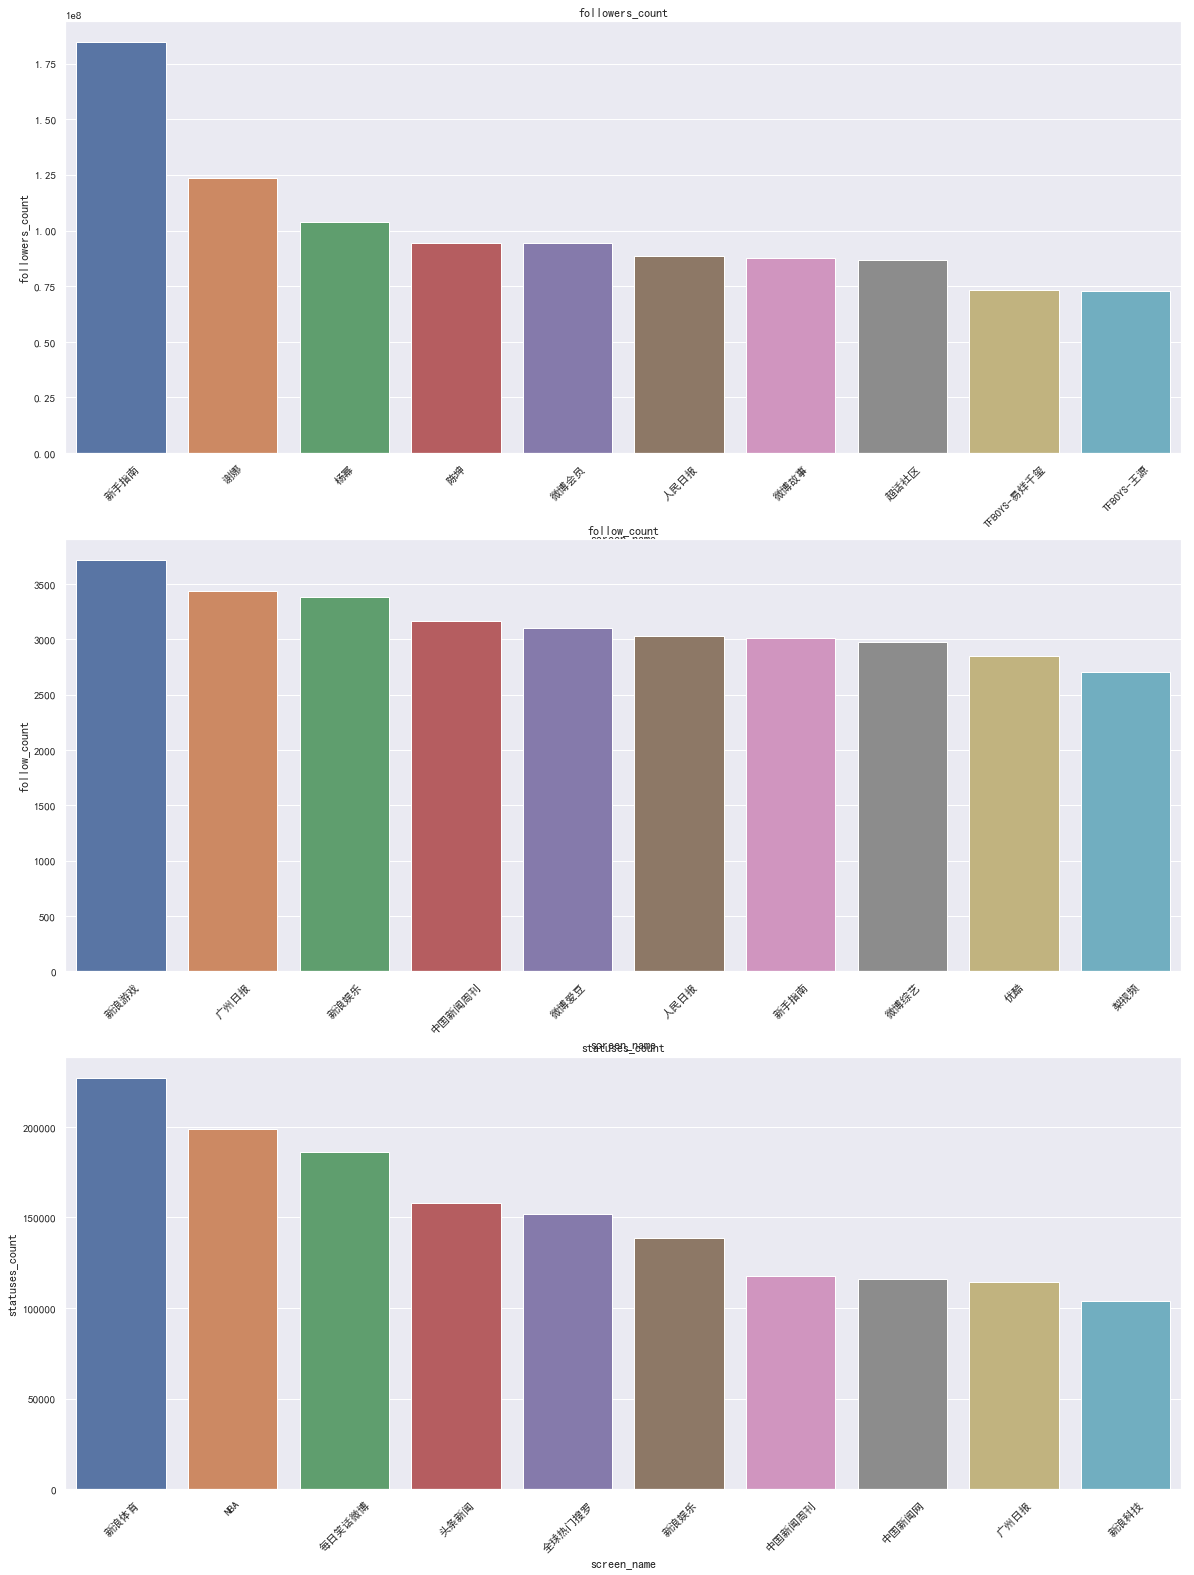

In [277]:
# 重点用户 # 关注属性
attrs = ['followers_count','follow_count','statuses_count']
plt.figure(figsize=(20,9*3))
for i,attr in enumerate(attrs):
    important_user_df = user_df.sort_values(attr,ascending=False)[:10]
    plt.subplot(311+i)
    plt.title(attr)
    plt.xticks(rotation=45)
    sns.barplot(x="screen_name", y=attr, data=important_user_df)

In [238]:
t = user_df.sort_values('statuses_count',ascending=False)[:10][['_id','screen_name','statuses_count']]
t['screen_name'].values

array(['新浪体育', 'NBA', '每日笑话微博', '头条新闻', '全球热门搜罗', '新浪娱乐', '中国新闻周刊',
       '中国新闻网', '广州日报', '新浪科技'], dtype=object)

In [237]:
t = user_df.sort_values('followers_count',ascending=False)[:10][['_id','screen_name','followers_count']]
t['followers_count'].values

array([184709270, 123807729, 103884540,  94210025,  94186440,  88488206,
        87726131,  86833582,  73174137,  72785480])

In [240]:
t = user_df.sort_values('follow_count',ascending=False)[:10][['_id','screen_name','follow_count']]
t['screen_name'].values

array(['新浪游戏', '广州日报', '新浪娱乐', '中国新闻周刊', '微博爱豆', '人民日报', '新手指南', '微博综艺',
       '优酷', '梨视频'], dtype=object)

#### 为每个用户生成一个微博的词云

In [8]:
font_path = './simhei.ttf'
stopword_path = './stopword.txt'
font = fm.FontProperties(fname=font_path, size=15)

In [9]:
stopwords = [w.strip() for w in open(stopword_path,'r').readlines()]

In [19]:
result = []
for user in user_table.find():
    uid = user['_id']
    post_cursor = post_table.find({'uid':uid})
    post = [t.get('text') for t in post_cursor]
    if post == []:
        continue
    for i in range(len(post)):
        post[i] = BeautifulSoup(post[i],'lxml').text
    text = '\n'.join(post)
    if uid == 2812335943:
        result.append({'uid':uid,'user':user,'text':text})

In [64]:
def analysis(data,img='./bg1.jpg'):
    uid = data['uid']
    screen_name = data['user']['screen_name']
    text = data['text']
    text +=' '.join(['希望父亲戒烟']*3)
    text +=' '.join(['道歉']*9)
    text +=' '.join(['抽烟餐厅']*5)
    text +=' '.join(['王源抽烟']*7)
    text +=' '.join(['皮肤']*5)
    print('uid = {}'.format(uid))
    print('user = {}'.format(data['user']['screen_name']))
    
    keywords = jieba.analyse.extract_tags(text, topK=20, withWeight=True, allowPOS=("n", "v",'a'))
    
    comm = pd.DataFrame(keywords)
    
    plt.figure(figsize=(20, 10))
    plt.bar(comm[0], comm[1], color="c")
    plt.xlabel('词语', fontproperties=font)
    plt.ylabel('权重',  fontproperties=font)
    plt.title('微博词频',  fontproperties=font)
    
    for a, b in zip(comm[0], comm[1]):
        plt.text(a, b, '%.2f' % b, ha='center', va='bottom', fontsize=16)
    plt.show()
    
    text = " ".join(jieba.cut(text, cut_all=False))
    mask = plt.imread(img)
    wc = WordCloud(font_path=font_path,
                    mask=mask,
                    width=1000,
                    height=600,
                    stopwords=stopwords,
                    mode='RGBA',
                    background_color='white').generate(text)

    plt.figure(figsize=(20, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.xticks(rotation=45)
    plt.axis('off')
    plt.show()
    wc.to_file("./{}_{}.png".format(uid,screen_name))

uid = 2812335943
user = TFBOYS-王源


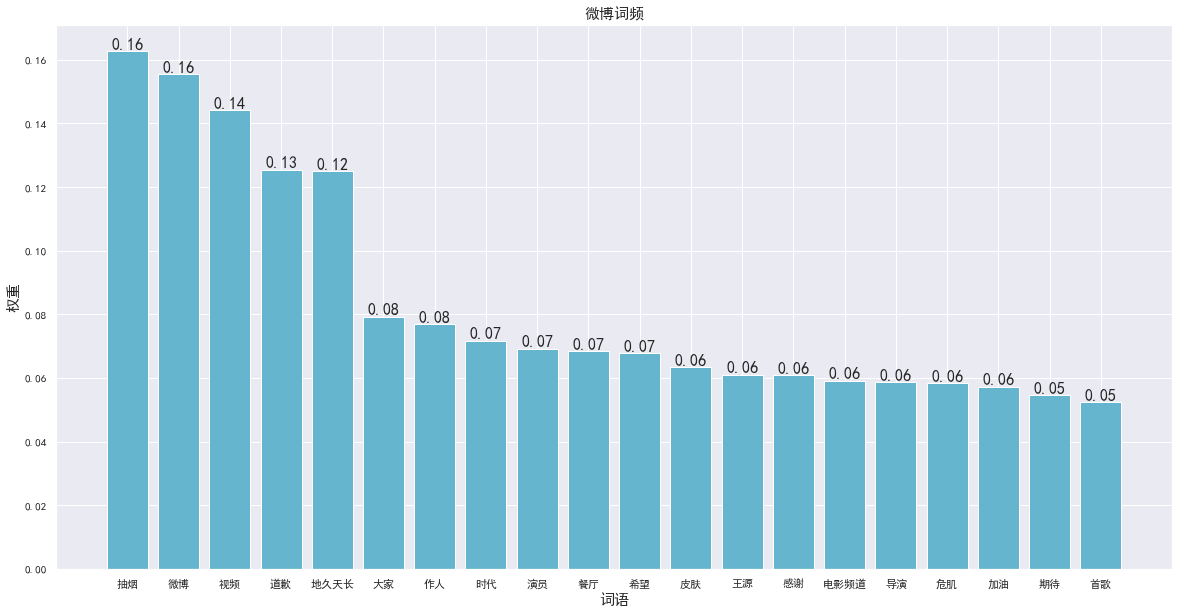

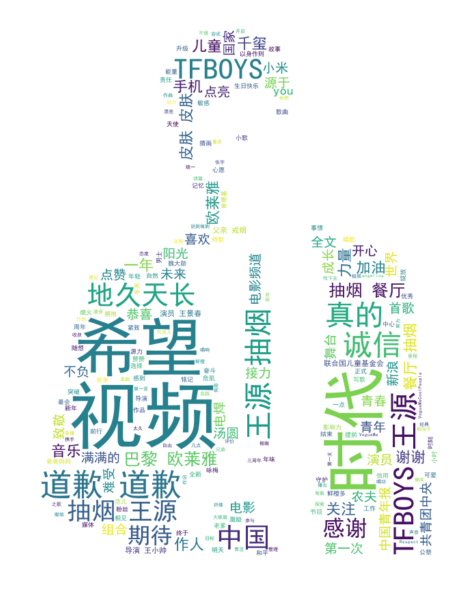

In [65]:
analysis(result[0])

In [31]:
# analysis(result[0],'./bg1.jpg')

In [243]:
def save_all(result,filter_uids=[]):
    if not os.path.exists('../img'):
        os.mkdir('../img')
    for data in result:
        uid = data['uid']
        if filter_uids!=[] and str(uid) not in filter_uids:
            continue
        screen_name = data['user']['screen_name']
        text = data['text']
        text = " ".join(jieba.cut(text, cut_all=False))
        mask = plt.imread('./bg1.jpg')
        wc = WordCloud(font_path=font_path,
                    mask=mask,
                    width=1000,
                    height=400,
                    stopwords=stopwords,
                    mode='RGBA',
                    background_color='white').generate(text)
        wc.to_file("../img/{}_{}.png".format(uid,screen_name))

In [244]:
save_all(result,filter_uids=filter_uids)

#### 用户影响力分析

In [135]:
user_dict = {}
for u in user_table.find():
    _id = str(u['_id'])
    dit = {'follower':0,'comments':0,'reposts':0,'weibo_num':0,'attitude':0,'prval':0}
    user_dict[_id] = dit
    user_dict[_id]['follower'] = u['followers_count']

In [136]:
for post in post_table.find():
    _id = str(post['uid'])
    if _id not in user_dict:
        continue
    else:        
        user = user_dict[_id]
        if isinstance(post['comments_count'],str):
            post['comments_count'] = 1000000
        if isinstance(post['reposts_count'],str):
            post['reposts_count'] = 1000000
        if isinstance(post['attitudes_count'],str):
            post['attitudes_count'] = 1000000
        user['comments'] += post['comments_count']
        user['reposts'] += post['reposts_count']
        user['attitude'] += post['attitudes_count']
        user['weibo_num'] += 1
        user_dict[_id] = user

In [278]:
def getPR(usr):
    sum_follower = usr['follower']
    sum_conment = usr['comments']
    sum_repost = usr['reposts']
    weiboNum = usr['weibo_num']
    sum_attitude = usr['attitude']
    pr = sum_follower*0.01 + (sum_repost*100 + sum_conment*30) * 1.0 /(weiboNum + 1)
    return pr

<Figure size 1440x864 with 0 Axes>

(array([0. , 0.2, 0.4, 0.6, 0.8, 1. ]), <a list of 6 Text xticklabel objects>)

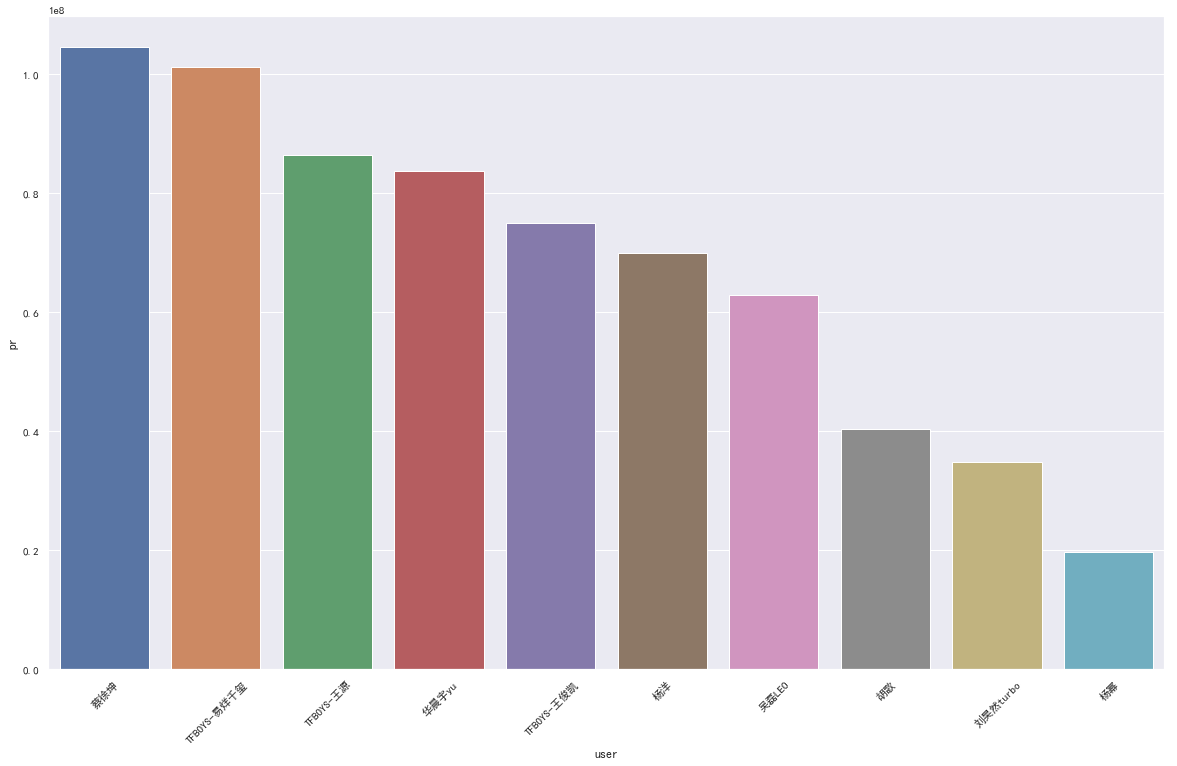

In [163]:
df = pd.DataFrame([k,user_table.find_one({'_id':int(k)})['screen_name'],getPR(user_dict[k])] for k in user_dict)
df.columns=['_id','user','pr']
data = df.sort_values('pr',ascending=False)[:10]

plt.figure(figsize=(20,12))
plt.xticks(rotation=45)
sns.barplot(data=data,x='user',y='pr')

In [280]:
# data['pr']/data['pr'].max()*100

In [281]:
# filter_uids = data['_id'].values.tolist()

In [282]:
# filter_uids

In [284]:
user_cloud[:5]

[{'name': '蔡徐坤', 'value': 104459082},
 {'name': 'TFBOYS-易烊千玺', 'value': 101211691},
 {'name': 'TFBOYS-王源', 'value': 86389552},
 {'name': '华晨宇yu', 'value': 83624676},
 {'name': 'TFBOYS-王俊凯', 'value': 74901556}]

###  获取指定用户的头像

In [167]:
base_url = 'https://m.weibo.cn/profile/info?uid={}'

import requests
headers = {
    'User-agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
    'Host': 'm.weibo.cn',
    'Accept': 'application/json, text/plain, */*',
    'Accept-Language': 'zh-CN,zh;q=0.8,en-US;q=0.5,en;q=0.3',
    'Accept-Encoding': 'gzip, deflate, br',
    'Referer': 'https://m.weibo.cn',
    'Cookie': "SUB=_2A25xuF6_DeRhGeFO71YT8SbEyj6IHXVTQ2L3rDV6PUJbkdAKLU39kW1NQX7CgYrX60fGGtm1i6iemR52JSQlwv7f; SUHB=0rrrYEQIdfaXig; SCF=AqEMR7DjEq8IoKbjhAVfKBVnwlb_liwr_1DYNDiBOupIChRW9rUU9-vfXrhq477vr0qbs6SINikWRMZW9b2MFRQ.; _T_WM=28248364669; MLOGIN=1; XSRF-TOKEN=0cf891; WEIBOCN_FROM=1110006030; M_WEIBOCN_PARAMS=luicode%3D20000174%26lfid%3D231016_-_selffans%26uicode%3D20000174",
    'Connection': 'keep-alive',
}

def get_img(uid):
    resp = requests.get(url=base_url.format(uid), headers=headers)
    if resp.status_code == 200:
        dct = json.loads(resp.text)
        return dct['data']['user']['profile_image_url']

img_list = []
for uid in data['_id']:
     img_list.append(get_img(uid))
print(img_list)

['https://tvax2.sinaimg.cn/crop.0.0.1125.1125.180/69e273f8ly8fuqt81zh3dj20v90v9abc.jpg', 'https://tvax2.sinaimg.cn/crop.0.0.996.996.180/d7f7faddly8fhx8l3fuiuj20ro0rojtn.jpg', 'https://tvax1.sinaimg.cn/crop.0.0.996.996.180/a7a0d747ly8fhx8k128s8j20ro0rogof.jpg', 'https://tva4.sinaimg.cn/crop.0.0.1080.1080.180/60da5d47jw8esd1q1zlzmj20u00u076v.jpg', 'https://tvax2.sinaimg.cn/crop.0.0.996.996.180/9b884b3bly8fhx93bz3rej20ro0rojtg.jpg', 'https://tvax2.sinaimg.cn/crop.0.0.1080.1080.180/6c351711ly8g2ioufp70gj20u00u0gpa.jpg', 'https://tva3.sinaimg.cn/crop.1.0.1240.1240.180/7fad39afjw8f7hemst7m4j20yi0ygq5x.jpg', 'https://tvax3.sinaimg.cn/crop.0.0.1125.1125.180/48e837eely8fukyqrf4ijj20v90v9mzy.jpg', 'https://tva2.sinaimg.cn/crop.0.0.1242.1242.180/ab179aaejw8f3xb0otda9j20yi0yj0yl.jpg', 'https://tva4.sinaimg.cn/crop.0.0.512.512.180/473df571jw8eku7gao4irj20e80e8dg7.jpg']


#### 用户画像

In [1]:
# 基本信息+行为属性[影响力,活跃度(转发,发博数量,频率)]+领域词(关键词)